In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.contrib.layers import fully_connected

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data_path= '../data/diamonds.csv'
diamonds = pd.read_csv(data_path)
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['cut'], prefix='cut', drop_first=True)],axis=1)
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['color'], prefix='color', drop_first=True)],axis=1)
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['clarity'], prefix='clarity', drop_first=True)],axis=1)
diamonds.drop(['cut','color','clarity'], axis=1, inplace=True)

In [3]:
from sklearn.preprocessing import RobustScaler
target_name = 'price'
robust_scaler = RobustScaler()
X = diamonds.drop('price', axis=1)
X = robust_scaler.fit_transform(X)
y = diamonds[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

In [4]:
n_epochs = 40
batch_size = 50 

In [8]:
X_placeholder = tf.placeholder(X_train.dtype, shape=X_train.shape)
y_placeholder = tf.placeholder(y_train.dtype, shape=y_train.shape)

dataset = tf.data.Dataset.from_tensor_slices((X_placeholder, y_placeholder))
dataset = dataset.shuffle(buffer_size=10000)
dataset = dataset.batch(batch_size)
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

In [9]:
n_inputs = X_train.shape[1] #23
n_hidden1 = 256
n_hidden2 = 128 
n_hidden3 = 64
n_outputs = 1

In [10]:
X = tf.placeholder(X_train.dtype, shape=[None,n_inputs])
y = tf.placeholder(y_train.dtype)

In [11]:
def DNN(X_values):
    hidden1 = fully_connected(X_values, n_hidden1)
    hidden2 = fully_connected(hidden1, n_hidden2)
    hidden3 = fully_connected(hidden2, n_hidden3)
    y_pred = fully_connected(hidden3, n_outputs, activation_fn=None)
    return tf.squeeze(y_pred)

In [12]:
y_pred = DNN(X)
loss = tf.losses.mean_squared_error(labels=y, predictions=y_pred)

In [13]:
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss)

In [14]:
train_mse = np.zeros(n_epochs)
test_mse = np.zeros(n_epochs)

In [15]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        sess.run(iterator.initializer, feed_dict={X_placeholder: X_train, y_placeholder: y_train})
        while True:
            try:
                batch_data = sess.run(next_element)
                X_batch = batch_data[0]
                y_batch = batch_data[1]
                sess.run(training_op, feed_dict={X: X_batch, y:y_batch})
            except tf.errors.OutOfRangeError:
                break
        print("=============EPOCH {}============".format(epoch+1))
        train_mse[epoch] = loss.eval(feed_dict={X:X_batch, y:y_batch})
        test_mse[epoch] = loss.eval(feed_dict={X:X_test, y:y_test})
        print('Training MSE:', round(train_mse[epoch],1))
        print('Test MSE:', round(test_mse[epoch],1))
    print("Done Trainning")
    
    ## Producing individual predictions
    print("\n=====================\n")
    print("Using the network to make individual predictions")
    n_pred = 25
    y_obs = y_test[:n_pred]
    y_predicted = y_pred.eval(feed_dict={X:X_test[:n_pred,]})
    print("Actual | Predicted")
    print("=====================") 
    for obs, pred in zip(y_obs, y_predicted):
        print("{: >8}   |{: >8}".format(round(obs), round(pred)))
    print("Correlation: ", np.corrcoef(y_obs, y_predicted)[0,1])

=============EPOCH 1============
Training MSE: 1487984.1
Test MSE: 945861.3
=============EPOCH 2============
Training MSE: 1324591.0
Test MSE: 763520.3
=============EPOCH 3============
Training MSE: 747295.4
Test MSE: 692744.2
=============EPOCH 4============
Training MSE: 582598.2
Test MSE: 648847.9
=============EPOCH 5============
Training MSE: 847241.3
Test MSE: 617727.9
=============EPOCH 6============
Training MSE: 211087.8
Test MSE: 577629.8
=============EPOCH 7============
Training MSE: 367640.2
Test MSE: 548181.0
=============EPOCH 8============
Training MSE: 483493.8
Test MSE: 523253.8
=============EPOCH 9============
Training MSE: 302357.0
Test MSE: 505584.0
=============EPOCH 10============
Training MSE: 342172.7
Test MSE: 507379.0
=============EPOCH 11============
Training MSE: 1254314.4
Test MSE: 476300.2
=============EPOCH 12============
Training MSE: 195476.0
Test MSE: 442623.9
=============EPOCH 13============
Training MSE: 477508.0
Test MSE: 438999.5
=============EPOCH

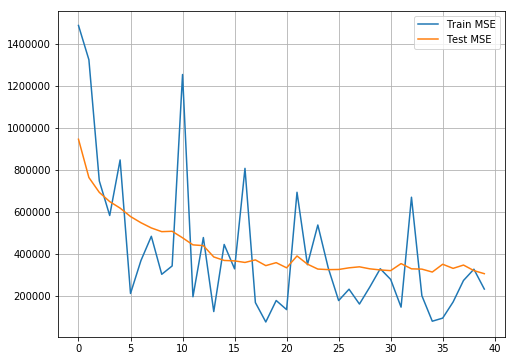

In [16]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(train_mse, label='Train MSE')
ax.plot(test_mse, label='Test MSE')
ax.legend()
ax.grid()